# Criação e Treinamento de Modelos para Predição da Pressão Sonora
Neste notebook jupyter de exemplo, veremos como usar o código de análise de som em tráfego para fazer a geração de um modelo para aprendizado de máquina. Esse código assume que o notebook para "extração de dados" dos vídeos já foi executado, iniciaremos com um modelo simples e ao final teremos um modelo treinado.
### Geração do Modelo
Primeiramente, vamos fazer a geração do modelo. A geração dos principais modelos já testados é bastante simples com esse código, como podemos ver a seguir:

In [1]:
import os, sys
import numpy as np

# Adiciona a pasta TrafficSoundAnalysis para o 'PATH', para que o python reconheça nosso pacote 
sys.path.append(os.path.dirname(os.path.abspath('')))

# Importa a classe DataHandler da nossa biblioteca de trafego
from TrafficSoundAnalysis.DataHandler.DataHandler import *
from TrafficSoundAnalysis.ModelHandler.ModelHandler import *

In [2]:
# Isso aqui é para resolve um problema de 'Out Of Memory' na minha gpu (GTX 1650)
# https://stackoverflow.com/questions/59873568/unknownerror-failed-to-get-convolution-algorithm
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

Vamos criar uma variavel para o nosso dataset já extraído. Tenha certeza de seguir o notebook para extração de dados!

In [3]:
# dataset_dir = '/home/.../traffic-analysis/Examples/dataset'
dataset_dir = os.path.join(os.path.abspath(''), "dataset")

#   Cria a pasta 'raw' em 'Examples/dataset/raw'
if not os.path.isdir(os.path.join(dataset_dir, "raw")):
    raise Exception("Por favor, complete antes o tutorial para extração do dataset!")

Vamos criar um objeto do tipo DataHandler para lidar com os dados extraídos

In [4]:
#   Cria o objecto dataHandler
dataHandler = DataHandler(dataset_directory = dataset_dir)

A partir daqui, vamos dar início a geração do nosso modelo. A classe básica do nosso modelo é a TrafficSoundAnalysis.Model. Vamos começar inicializando um objeto dessa classe

In [5]:
#   Cria um objeto do tipo ModelHandler() para geração do nosso modelo
model = ModelHandler()

O objeto do tipo ModelHandler ainda não está inicializado, ou seja, não há de fato nenhum modelo keras "guardado" nele. Para inicializa-lo, precisamos chamar algum método do tipo "Build". Existem duas formas básicas de inicializar esse objeto:

1. Usando um dicionário python pré-definido.
2. Passando para ele diretamente um modelo keras.

A inicialização usando o dicionário python é útil pela facilidade da geração do modelo. Só é preciso passar alguns parâmetros, e o modelo automaticamente gera o modelo correspondente para o Keras.

Já a inicialização passando diretamente um modelo Keras é útil por sua maior abrangência, permitindo o uso de modelos não previamente criados.

Vamos dar um exemplo para cada

1. #### Inicialização de modelo por dicionário python

Vamos primeiro ver qual o formato do nosso dicionário, criando um exemplo

In [6]:
#   Modelo de dicionario python para definicao de uma rede
network = dict()

#   Model and training configuration
network['model_name'] = 'training_example'
network['input_format'] = [64, 64, 3]

#   Convolutional layer
network['cnn'] = 'vgg16' #or inceptionv3, or resnet50
network['cnn_offline'] = False
network['cnn_freeze_imagenet_weights'] = True

#   Pooling layer
network['pooling'] = 'gap'  #or 'none', or 'gmp'

#   RNN Layer
network['rnn'] = 'lstm' #   or 'lstm'
network['rnn_timesteps'] = 10
network['rnn_outputsize'] = 64
network['rnn_dropout'] = 0.2
network['rnn_isstateful'] = False

#   Hidden FC layer
network['hiddenfc'] = True
network['hiddenfc_size'] = 64
network['hiddenfc_activation'] = 'tanh'
network['hiddenfc_regularizer'] = None
network['hiddenfc_dropout'] = 0

#   Dataset related things
network['dataset_overlapwindows'] = True
network['dataset_causalprediction'] = False

Agora só precisamos chamar o método BuildModelFromDictionary, passando por parâmetro nosso dicionário

In [7]:
model.BuildModelFromDictionary(network)

# O modelo keras gerado fica salvo no parametro '.model' do nosso objeto.
# Vamos sumarizar o modelo gerado:

# Summary
model.model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 10, 2, 2, 512)     14714688  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 512)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                147712    
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 14,866,625
Trainable params: 151,937
Non-trainable params: 14,714,688
______________________________________

In [8]:
# Vamos gerar um modelo agora sem a camada LSTM desse modelo
network['rnn'] = 'none'

# Faz a geração do modelo
model.BuildModelFromDictionary(network)

# Summary
model.model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                32832     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 14,747,585
Trainable params: 32,897
Non-trainable params: 14,714,688
__________________________________________

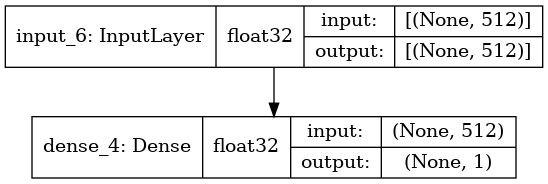

In [9]:
# Vamos gerar um modelo agora usando a vgg16 'offline', ou seja, usando as features já previamente salvas da vgg16
# Vamos também desativar a camada hidden_fc
network['cnn_offline'] = True
network['hiddenfc'] = False

# Faz a geração do modelo
model.BuildModelFromDictionary(network)

# Também podemos vizualizar o modelo com o método ShowModel()
from IPython.display import Image

model.ShowModel()
Image(filename='model.png')

2. #### Inicialização de modelo diretamente por um modelo Keras

Digamos que nós queiramos testar um modelo diferente, não implementado. Podemos diretamente escrever esse modelo e inicializar nosso objeto ModelHandler com ele. Por exemplo:

In [10]:
## Geração de um modelo mobilenet para nosso projeto
input_format = (64, 64, 3)

# Baixa a rede mobilenet do keras.applications e congela seus pesos
convolutional_layer = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=input_format)
for layer in convolutional_layer.layers[:]:
    layer.trainable = False

# Cria um modelo do tipo sequencial
mobile_net = tf.keras.Sequential(name='mobile_net_test')

mobile_net.add(tf.keras.layers.Input(input_format))
mobile_net.add(convolutional_layer)
mobile_net.add(tf.keras.layers.GlobalAveragePooling2D(data_format=None))

mobile_net.add(tf.keras.layers.Dense(128, activation='tanh'))
mobile_net.add(tf.keras.layers.Dropout(0.2))
mobile_net.add(tf.keras.layers.Dense(1, activation='linear'))

# Summarize
mobile_net.summary()

Model: "mobile_net_test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 2, 2, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 3,360,193
Trainable params: 131,329
Non-trainable params: 3,228,864
_________________________________________________________________


In [12]:
# Agora vamos simplesmente passar esse modelo para a classe ModelHandler:
# Esse método simplesmente checa se o modelo gerado é um modelo keras válido,
# e o copia para seu parametro interno .model

model.BuildModelFromKeras(mobile_net)

# Show model
model.model.summary()

Model: "mobile_net_test"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 2, 2, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               131200    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 3,360,193
Trainable params: 131,329
Non-trainable params: 3,228,864
_________________________________________________________________


### Treinamento de redes neurais

Ainda em andamento...